In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime, timedelta
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.forecasting.stl import STLForecast

In [2]:
plt.rcParams['figure.figsize'] = [13, 9]

## EDA

In [3]:
def read_orders(filename):
    orders = pd.read_csv(filename)
    orders.order_date = pd.to_datetime(orders.order_date)
    
    return orders

In [4]:
orders = read_orders("../data/orders.csv")

In [5]:
orders.shape

(978, 9)

In [6]:
# id is the order id field
len(orders.id.unique())

978

In [7]:
# This dataset has only one company
orders.company.unique()

array(['4db8c0cdd9ef'], dtype=object)

In [8]:
# Three Products in this data
orders['product'].unique()

array(['3556d56cab2a', 'b9da9eef0e7a', 'f78a4d819600'], dtype=object)

In [9]:
# 009, 0014 and 020
orders[['product', 'product_sku', 'product_family_1', 'product_family_2', 'product_family_3']].drop_duplicates()
# prodcut family columns are all the same for this data

,product,product_sku,product_family_1,product_family_2,product_family_3
0,3556d56cab2a,BANDANA009,Toy,Toy,TOYS_AND_GAMES
219,b9da9eef0e7a,BANDANA014,Toy,Toy,TOYS_AND_GAMES
752,f78a4d819600,BANDANA020,Toy,Toy,TOYS_AND_GAMES


## Plotting

In [10]:
def order_plot(data, style="panel"):
    orders = data.copy()
    order_plot_fn = _get_plot_style(style)
    order_plot_fn(orders)
    
def _get_plot_style(style):
    if style == "panel":
        return _order_plot_panel
    elif style == "alltogether":
        return _order_plot_alltogether
    
def _order_plot_panel(orders):
    # One Panel for each product
    unique_skus = orders.product_sku.unique()
    colors = ['blue', 'red', 'green']
    fig, ax_list = plt.subplots(len(unique_skus), 1, figsize=(14,10), sharex=True)

    # gridlines
    xcoords = ['2019-01-01', '2020-01-01','2021-01-01']
    
    # linestyles for forecasts/sales
    if 'forecast_type' not in orders.columns:
        orders['forecast_type'] = 'sales'
    
    for i, sku in enumerate(unique_skus):
        sku_orders = orders[orders.product_sku == sku]
        sku_forecast = sku_orders[sku_orders['forecast_type'] == 'forecast']
        sku_orders = sku_orders[sku_orders['forecast_type'] == 'sales']
        ax = ax_list[i]
        # sales plot
        ax.plot(
            sku_orders['order_date'], 
            sku_orders['order_quantity'], 
            color=colors[i], 
            label=sku, 
            linestyle='-'
        )
        # forecast plot
        ax.plot(
            sku_forecast['order_date'], 
            sku_forecast['order_quantity'], 
            color=colors[i], 
            label=sku, 
            linestyle='--'
        )

        ax.set_title(sku)
        ax.legend()
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
        ax.xaxis.set_major_locator(mdates.AutoDateLocator())
        for xc in xcoords:
            ax.axvline(x=datetime.strptime(xc, "%Y-%m-%d"), color='black', linestyle='--')

    plt.plot()
    
def _order_plot_alltogether(orders):
    skus = orders.product_sku.unique()
    fig, ax = plt.subplots(1, 1, figsize=(14, 10))
    xcoords = ['2019-01-01', '2020-01-01','2021-01-01']

    for sku in skus:
        sku_orders = orders[orders.product_sku == sku]
        ax.plot(sku_orders['order_date'], sku_orders['order_quantity'], label=sku)
        ax.set_xticklabels(ax.get_xticks(), rotation = 45)
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%b'))
        ax.xaxis.set_major_locator(mdates.AutoDateLocator())

    ax.set_title("Time Series Sales")
    for xc in xcoords:
        ax.axvline(x=datetime.strptime(xc, "%Y-%m-%d"), color='black', linestyle='--')

    ax.legend()

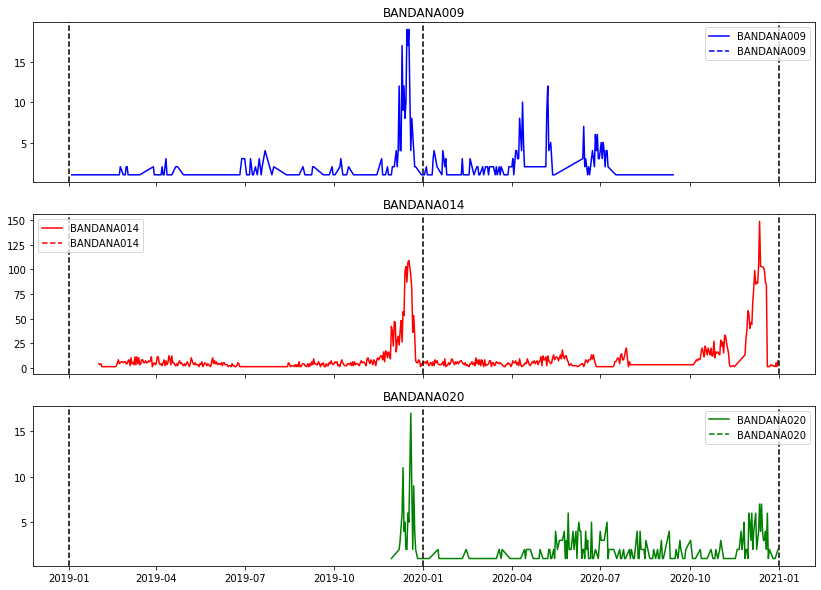

In [11]:
order_plot(orders, style="panel")

### Plot Summary

Three Products all have similar seasonality. 
(Basic retail seasonality with more sales in summer and during retail peak season)

None of the three products have 2 full periods.
This makes it difficult to estimate seasonality

Imputation Strategy:
- Dumb mode: copy Bandana014 sales from 2020 into 2019
- More Sophisticated: aggregate sales accross products to impute missing sales timeframes

Bandana 014 has much higher sales volume than the others. We will need to standardize quantities before combining products together

There are multiple stockout periods where the retailer appears to have run out of inventory which halts sales.
For example DogBandana014 is OOS from around August - September in 2020.
Since our demand is censored in these periods this will bring our demand estimate lower than reality.

## Inpute Missing Data

### Fill in Jan 2019

In [12]:
def impute_missing_sales(data):
    ''' Impute orders when a product was not actively sold 
    
    If a product was not live, use the other year of sales data to impute the missing data
    '''        
    orders = data.copy()
    b009_orders = orders[
        (orders.product_sku=="BANDANA009") &
        (orders.order_date > '2019-09-14') &
        (orders.order_date < '2019-12-31')
    ].copy()
    b014_orders = orders[
        (orders.product_sku=="BANDANA014") &
        (orders.order_date >= '2020-01-01') &
        (orders.order_date <= '2020-01-21')
    ].copy()
    b020_orders = orders[
        (orders.product_sku=="BANDANA020") &
        (orders.order_date >= '2020-01-01') &
        (orders.order_date <= '2020-11-28')
    ].copy()

    b009_orders.order_date = b009_orders.order_date.apply(
        lambda d: datetime.strptime('2020-' + datetime.strftime(d, '%Y-%m-%d')[5:], '%Y-%m-%d')
    )
    b014_orders.order_date = b014_orders.order_date.apply(
        lambda d: datetime.strptime('2019-' + datetime.strftime(d, '%Y-%m-%d')[5:], '%Y-%m-%d')
    )
    b020_orders.order_date = b020_orders.order_date.apply(
        lambda d: datetime.strptime('2019-' + datetime.strftime(d, '%Y-%m-%d')[5:], '%Y-%m-%d')
    )
    
    imputed_orders = pd.concat([orders, b009_orders, b014_orders, b020_orders])
    imputed_orders.sort_values(['product_sku', 'order_date'], inplace=True)
    
    return imputed_orders

In [13]:
imputed_orders = impute_missing_sales(orders)

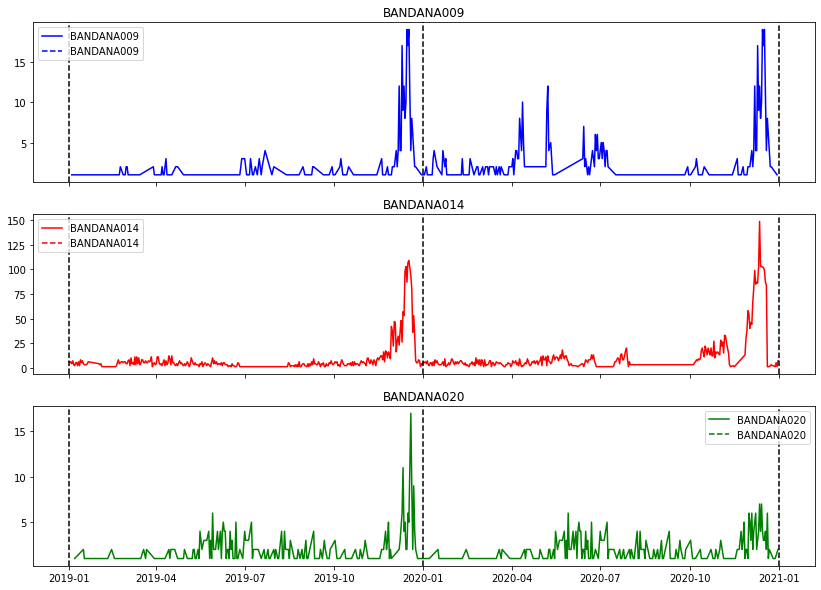

In [14]:
order_plot(imputed_orders)

In [15]:
def shift_dates(data):
    '''
    Shift the sales history of Bandana009 and Bandana020 back in time 
    so that we have one long ts from which to estimate seasonality
    '''
    orders = data.copy()
    orders['year'] = orders.order_date.dt.isocalendar().year
    orders['week'] = orders.order_date.dt.isocalendar().week
    orders['day'] = orders.order_date.dt.isocalendar().day
    def _shift(row):
        if row['product_sku'] == 'BANDANA009':
            shift_year = row['year'] - 2
        elif row['product_sku'] == 'BANDANA020':
            shift_year = row['year'] - 4
        else:
            shift_year = row['year']
        return shift_year

    orders['shift_year'] = orders.apply(_shift, axis=1)
    orders['order_date'] = orders.apply(
        lambda row: f'{row["shift_year"]}-{row["week"]}-{row["day"]}',
        axis=1
    )
    orders.order_date = orders.order_date.apply(lambda d: datetime.strptime(d, "%G-%V-%u"))
    orders.order_date = pd.to_datetime(orders.order_date)
    
    orders.drop(columns=['year', 'week', 'day', 'shift_year'], inplace=True)
    orders.sort_values(['product_sku', 'order_date'], inplace=True)
    
    return orders

In [16]:
orders_shift = shift_dates(imputed_orders)

/home/allen/.local/lib/python3.6/site-packages/ipykernel_launcher.py:64: UserWarning: FixedFormatter should only be used together with FixedLocator
/home/allen/.local/lib/python3.6/site-packages/ipykernel_launcher.py:64: UserWarning: FixedFormatter should only be used together with FixedLocator
/home/allen/.local/lib/python3.6/site-packages/ipykernel_launcher.py:64: UserWarning: FixedFormatter should only be used together with FixedLocator


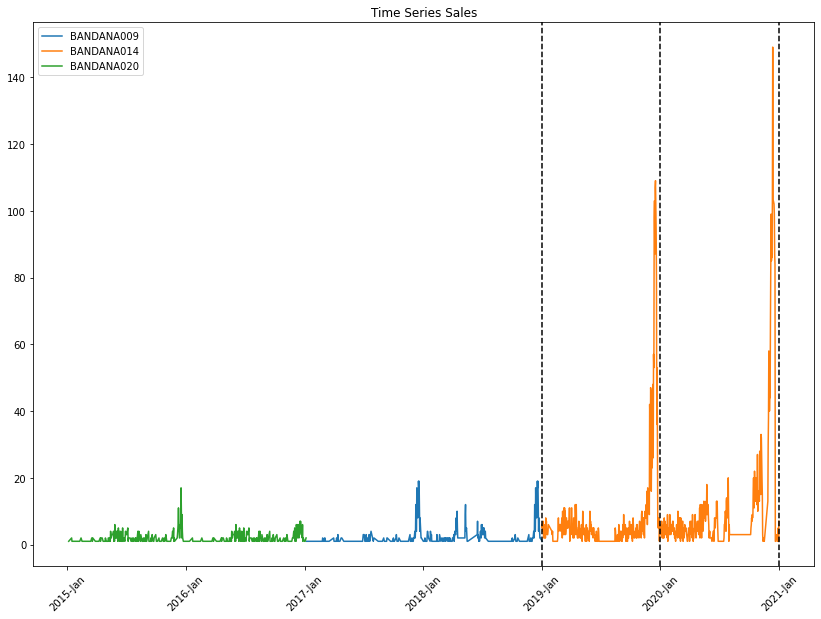

In [17]:
order_plot(orders_shift, 'alltogether')

## Normalize Product Order Quantities

In [18]:
def normalize_products(data):
    ''' 
    Normalize the product volumes
    '''
    
    orders = data.copy()
    
    # product totals
    order_counts = orders.groupby(['product_sku']).agg(sku_total = ('order_quantity', 'sum'))
    orders = orders.merge(order_counts, how='left', on='product_sku')
    orders.order_quantity = orders.order_quantity / orders.sku_total
    
    b14 = order_counts[order_counts.index=='BANDANA014']
    print(b14.sku_total[0])
    
    orders.order_quantity = orders.order_quantity * order_counts.sku_total[
        order_counts.index=='BANDANA014'
    ][0]
    
    return orders

In [19]:
orders_norm = normalize_products(orders_shift)

6018


/home/allen/.local/lib/python3.6/site-packages/ipykernel_launcher.py:64: UserWarning: FixedFormatter should only be used together with FixedLocator
/home/allen/.local/lib/python3.6/site-packages/ipykernel_launcher.py:64: UserWarning: FixedFormatter should only be used together with FixedLocator
/home/allen/.local/lib/python3.6/site-packages/ipykernel_launcher.py:64: UserWarning: FixedFormatter should only be used together with FixedLocator


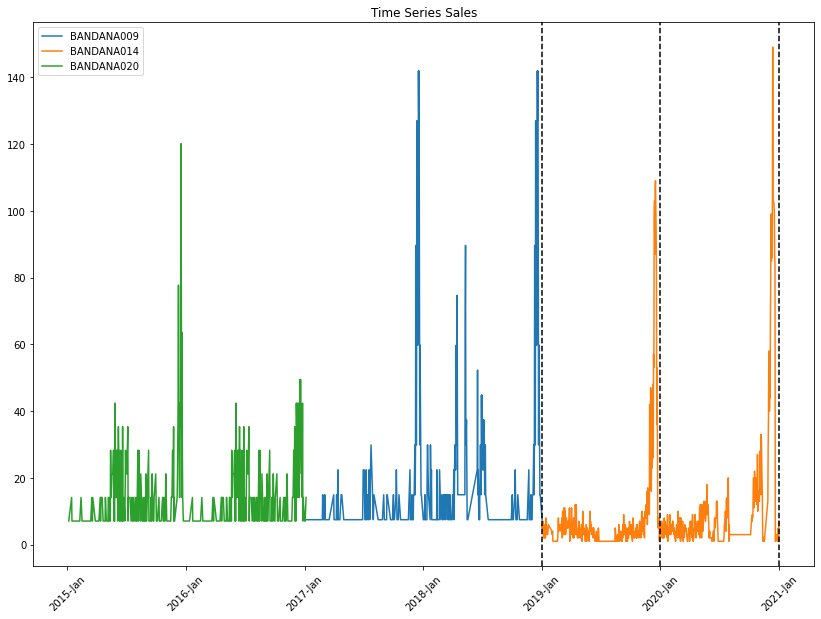

In [20]:
order_plot(orders_norm, "alltogether")

## Smoothing the Orders

Smooth at weekly grain


In [21]:
def smooth(data, time_grain='W'):
    orders = data.copy()
    
    beg_d = f'{orders.order_date.dt.year.min()}-01-01'
    end_d = f'{orders.order_date.dt.year.max()}-12-31'
    
    dr = pd.date_range(beg_d, end_d)
    
    index = pd.MultiIndex.from_product(
        [orders.product_sku.unique(), dr], 
        names = ['product_sku', 'order_date']
    )

    full_dr = pd.DataFrame(index=index).reset_index()
    orders = orders.merge(
        full_dr,
        how='outer',
        on=['product_sku', 'order_date']
    )
    orders.order_quantity = orders.order_quantity.fillna(0)
    orders.set_index('order_date', inplace=True)
    
    time_series = orders.order_quantity.resample(time_grain).sum()
    
    return time_series

In [22]:
ts = smooth(orders_norm)

<AxesSubplot:xlabel='order_date'>

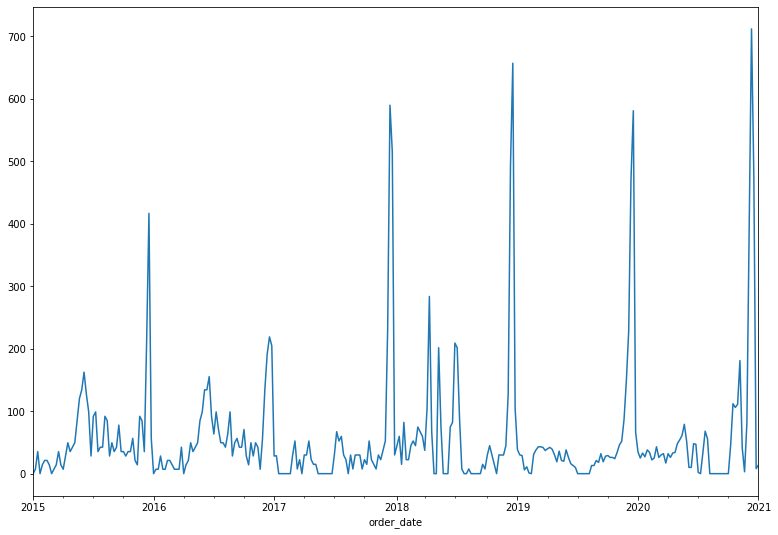

In [23]:
ts.plot()

## Seasonal Decomposition and Forecasting

In [29]:
def forecast(ts):
    stlf = STLForecast(
        ts,
        ARIMA,
        model_kwargs=dict(order=(1, 1, 0), trend="t")
    )
    stlf_res = stlf.fit()
    forecast = stlf_res.forecast(53)
    forecast.index.name = "order_date"
    forecast.name = "order_quantity"
    forecast = forecast.reset_index()
    forecast['id'] = np.NaN
    forecast['company'] = '4db8c0cdd9ef'
    forecast['product'] = 'b9da9eef0e7a'
    forecast['product_sku'] = 'BANDANA014'
    forecast['product_family_1'] = 'Toy'
    forecast['product_family_2'] = 'Toy'
    forecast['product_family_3'] = 'TOYS_AND_GAMES'
    forecast['forecast_type'] = 'forecast'
    forecast = forecast[[
        'id', 'company', 'product', 'product_sku', 'product_family_1',
        'product_family_2', 'product_family_3', 'order_quantity', 'order_date',
        'forecast_type'
    ]]
    return forecast

fc = forecast(ts)
fc.head()


AttributeError: 'STLForecast' object has no attribute 'plot'

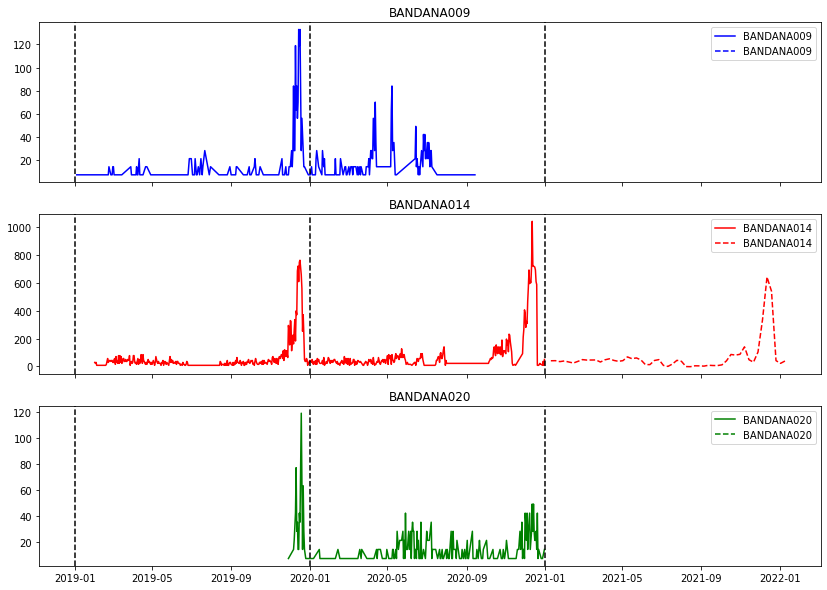

In [28]:
all_data = orders.copy()
all_data['forecast_type'] = 'sales'
all_data['order_quantity'] = all_data['order_quantity'] * 7
all_data = pd.concat([all_data, fc])
all_data.sort_values(['product_sku', 'order_date'], inplace=True)
order_plot(all_data)

In [30]:
final = pd.read_csv("../data/forecast_BANDANA014.csv")
final.head()

,product_sku,year,week,forecast_type,order_quantity
0,BANDANA009,2019,1,sales,1.0
1,BANDANA009,2019,8,sales,4.0
2,BANDANA009,2019,9,sales,7.0
3,BANDANA009,2019,10,sales,1.0
4,BANDANA009,2019,11,sales,3.0


In [32]:
    def plot_forecast(results):
        '''
        Plot the Sales History and Forecast
        '''
        results['order_date'] = results.apply(
            lambda row: f'{row["year"]}-{row["week"]}-1',
            axis=1
        )
        results.order_date = pd.to_datetime(results.order_date, format='%G-%V-%u')

        unique_skus = results.product_sku.unique()
        colors = ['blue', 'red', 'green']
        fig, ax_list = plt.subplots(len(unique_skus), 1, figsize=(14, 10), sharex=True)

        # gridlines
        xcoords = ['2019-01-01', '2020-01-01', '2021-01-01']

        for i, sku in enumerate(unique_skus):
            sku_orders = results[results.product_sku == sku]
            sku_forecast = sku_orders[sku_orders['forecast_type'] == 'forecast']
            sku_orders = sku_orders[sku_orders['forecast_type'] == 'sales']
            ax = ax_list[i]

            # sales plot
            ax.plot(
                sku_orders['order_date'],
                sku_orders['order_quantity'],
                color=colors[i],
                label=sku,
                linestyle='-'
            )

            # forecast plot
            ax.plot(
                sku_forecast['order_date'],
                sku_forecast['order_quantity'],
                color=colors[i],
                label=sku,
                linestyle='--'
            )

            ax.set_title(sku)
            ax.legend()
            ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
            ax.xaxis.set_major_locator(mdates.AutoDateLocator())

            for xc in xcoords:
                ax.axvline(x=datetime.strptime(xc, "%Y-%m-%d"), color='black', linestyle='--')

        plt.plot()


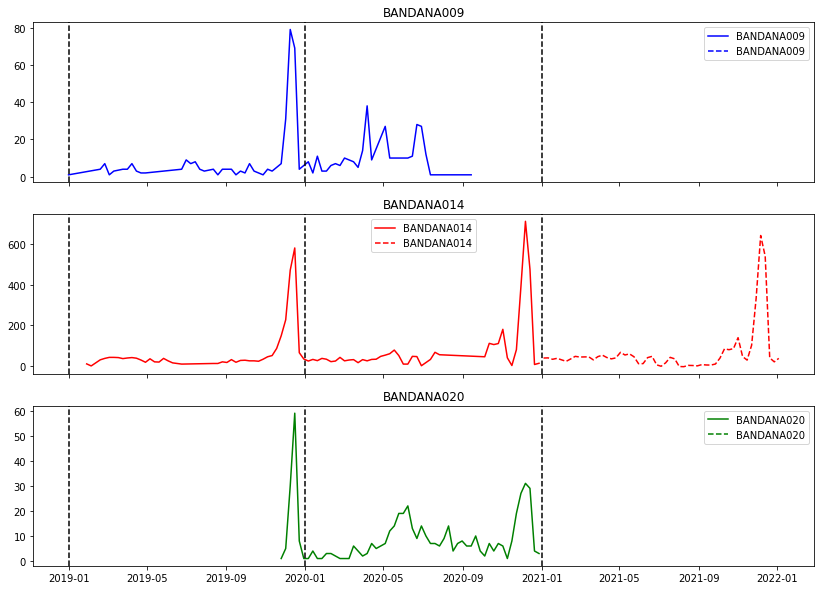

In [33]:
plot_forecast(final)